# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install torch==1.13.0
!install tensorflow==2.8.0
!pip install tensorflow==2.8.0

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale

path1 = '/kaggle/input/qsar-model/HDAC3/2D/'
path2= '/kaggle/input/qsar-model/HDAC3/3D/'
path3= '/kaggle/input/qsar-model/HDAC3/'

# Read data
DMorse = pd.read_csv(path2+'3DMorse.csv').iloc[:, 1:]
AP3D = pd.read_csv(path2+'AP3D.csv').iloc[:, 1:]
EC3P = pd.read_csv(path2+'EC3P.csv').iloc[:, 1:]
RDK3D = pd.read_csv(path2+'RDK3D.csv').iloc[:, 1:]

# Read data
AP2D = pd.read_csv(path1+'AP2D.csv').iloc[1:, 1:]
AP2DC = pd.read_csv(path1+'AP2DC.csv').iloc[1:, 1:]
CDK = pd.read_csv(path1+'CDK.csv').iloc[1:, 1:]
CDKExt = pd.read_csv(path1+'CDKExt.csv').iloc[1:, 1:]
CDKGraph = pd.read_csv(path1+'CDKGraph.csv').iloc[1:, 1:]
EState = pd.read_csv(path1+'EState.csv').iloc[1:, 1:]
FP4 = pd.read_csv(path1+'FP4.csv').iloc[1:, 1:]
FP4C = pd.read_csv(path1+'FP4C.csv').iloc[1:, 1:]
KR = pd.read_csv(path1+'KR.csv').iloc[1:, 1:]
KRC = pd.read_csv(path1+'KRC.csv').iloc[1:, 1:]
MACCS = pd.read_csv(path1+'MACCS.csv').iloc[1:, 1:]
Morgan = pd.read_csv(path1+'Morgan.csv').iloc[1:, 1:]
Pubchem = pd.read_csv(path1+'Pubchem.csv').iloc[1:, 1:]
RDK5 = pd.read_csv(path1+'RDK5.csv').iloc[1:, 1:]
oneDfeat = pd.read_csv(path3+'1D.csv').iloc[1:,1:]

combine_datat = np.column_stack((AP2D, AP2DC, CDK, CDKExt, CDKGraph, EState, FP4, FP4C, KR, KRC, MACCS, Morgan, Pubchem,RDK5))
data_train=np.array(dataset)
data_train=data_train[:1106,:]
[m1,n1]=np.shape(data_train)
# label1=np.ones((int(598),1))#Value can be changed
# label2=np.zeros((int(508 ),1))
label1=np.ones((598,1))#Value can be changed
label2=np.zeros((508,1))
label=np.append(label1,label2)
shu=scale(data_train)
X=shu
y=label

In [ ]:
import os
import sys
import math
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import scale
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Input, Dense, Layer, Reshape, Flatten
from tensorflow.keras.layers import multiply, Add, Permute
from tensorflow.keras.layers import Dropout, Lambda, Concatenate, Multiply
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.optimizers import adam_v2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA


BiLSTM=pd.read_csv(r'/kaggle/input/qsar-model/all_BiLSTM_train_2D.csv',header=None)

Attention = pd.read_csv(r'/kaggle/input/qsar-model/all_atten_train_2D.csv',header=None)

dataset = np.column_stack((BiLSTM, Attention,combine_datat))

data_train=np.array(dataset)
data_train=data_train[:1106,:]
[m1,n1]=np.shape(data_train)
# label1=np.ones((int(598),1))#Value can be changed
# label2=np.zeros((int(508 ),1))
label1=np.ones((598,1))#Value can be changed
label2=np.zeros((508,1))
label=np.append(label1,label2)
shu=scale(data_train)

# Apply PCA
pca = PCA(n_components=0.75)  # Keep 95% of the variance
data_train_pca = pca.fit_transform(shu)

print("Original shape:", shu.shape)
print("Transformed shape:", data_train_pca.shape)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(shu, label, test_size=0.2, random_state=42)


# Assuming X_train_whole = scale(X_train_whole)
[sample_num, input_dimwx] = np.shape(X_train)
X = X_train
y = y_train
xt = X_test
yt = y_test


def get_shuffle(data, label):
    index = np.arange(len(label))
    np.random.shuffle(index)
    return data[index], label[index]

X, y = get_shuffle(X, y)

def scale_mean_var(input_arr, axis=0):
    mean_ = np.mean(input_arr, axis=0)
    scale_ = np.std(input_arr, axis=0)
    output_arr = input_arr - mean_
    mean_1 = output_arr.mean(axis=0)
    if not np.allclose(mean_1, 0):
        output_arr -= mean_1
    scale_[scale_ == 0.0] = 1.0
    output_arr /= scale_
    mean_2 = output_arr.mean(axis=0)
    if not np.allclose(mean_2, 0):
        output_arr -= mean_2
    return output_arr

########################################################### Def Cbam
def channel_attention(input_feature, ratio=8):
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	shared_layer_one = Dense(channel//ratio,
							 kernel_initializer='he_normal',
							 activation = 'relu',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('hard_sigmoid')(cbam_feature)
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
	kernel_size = 7
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					activation = 'hard_sigmoid',
					strides=1,
					padding='same',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	return multiply([input_feature, cbam_feature])


def cbam_block(cbam_feature,ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature, )
	return cbam_feature


############################################## Def discriminator and generator
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

def build_discriminator():
    img = Input(shape=(1,input_dimwx,1))
    x = Conv2D(filters=64, kernel_size=(1,9), strides=2, padding='valid', name='conv1')(img)
    x = LeakyReLU()(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(filters=32, kernel_size=(1,9), strides=2, padding='valid', name='conv1')(img)
    x = LeakyReLU()(x)
    x = BatchNormalization(momentum=0.8)(x)

    """
    NOTE: Capsule architecture starts from here.
    """
    ##### primarycaps coming first #####
    x = Conv2D(filters=32, kernel_size=(1,3), strides=2, padding='valid', name='primarycap_conv2')(x)
    [aa,bb,cc,dd] = x.shape
    numx = int(cc)
    x = Reshape(target_shape=[-1, numx], name='primarycap_reshape')(x)
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)

    ##### digitcaps are here #####
    x = Flatten()(x)
    uhat = Dense(128, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    c = Activation('softmax', name='softmax_digitcaps1')(uhat) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(128)(c) # compute s_j
    x = Multiply()([uhat, c])
    """
    NOTE: Squashing the capsule outputs creates severe blurry artifacts, thus we replace it with Leaky ReLu.
    """
    s_j = LeakyReLU()(x)
    ##### we will repeat the routing part 2 more times (num_routing=3) to unfold the loop
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(128)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(128)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps4')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(128)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)
    # ##### preparition for cbam_block
    s_j = Reshape((-1,128,1))(s_j)
    inputs = s_j
    residual = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', name='convxxx')(inputs)
    residual = BatchNormalization(momentum=0.8)(residual)

    cbam = cbam_block(residual)
    # cbam = channel_attention(residual)
    # cbam = spatial_attention(residual)

    cbam = Reshape((-1,))(cbam)
    pred = Dense(2, activation='sigmoid')(cbam)

    # cbam = Reshape((-1,))(s_j)
    # pred = Dense(2, activation='sigmoid')(cbam)


    return Model(img, pred)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])


# generator structure
def build_generator():
    """
    Generator follows the DCGAN architecture and creates generated image representations through learning.
    """
    noise_shape =(input_dimwx,)
    x_noise = Input(shape=noise_shape)
    # we apply different kernel sizes in order to match the original image size
    x = Dense(64 * 1 * input_dimwx, activation="relu")(x_noise)
    x = Reshape((1, input_dimwx, 64))(x)
    x = BatchNormalization(momentum=0.2)(x)
    x = UpSampling2D()(x)
    [aa1,bb1,cc1,dd1] = x.shape
    numx1 = int(cc1//4)
    x = Conv2D(32, kernel_size=(2,numx1), padding="valid")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.2)(x)
    [aa2,bb2,cc2,dd2] = x.shape
    #### x = UpSampling2D()(x)
    numx2 = int(1+cc2-input_dimwx)
    x = Conv2D(16, kernel_size=(1,numx2), padding="valid")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.2)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    gen_out = Activation("tanh")(x)

    return Model(x_noise, gen_out)

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.002, 0.8), metrics=['binary_accuracy'])

# feeding noise to generator
z = Input(shape=(input_dimwx,))
img = generator(z)
# for the combined model we will only train the generator
discriminator.trainable = False
# try to discriminate generated images
valid = discriminator(img)
# the combined model (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.002, 0.8), metrics=['binary_accuracy'])
#########################################################
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y) + 1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP = []

mean_recall = np.linspace(0, 1, 100)
all_precision = []
base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
interp_tpr_collection = []

# Define the directory to save the models
save_dir = '/kaggle/working/models/'

skf = StratifiedKFold(n_splits=10)
for fold, (train, test) in enumerate(skf.split(X, y)):
    X_train, X_valid, y_train, y_valid = X[train], X[test], y[train], y[test]
    y_train = to_categorical(y_train)

    # Reinitialize and compile models for each fold
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.002, 0.8), metrics=['binary_accuracy'])

    z = Input(shape=(input_dimwx,))
    img = generator(z)
    discriminator.trainable = False
    valid = discriminator(img)
    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.002, 0.8), metrics=['binary_accuracy'])

    # Define checkpoint callback to save the best model
    model_checkpoint = ModelCheckpoint(os.path.join(save_dir, f'model_fold_{fold+1}.h5'),
                                       save_best_only=True,
                                       monitor='val_loss',
                                       mode='min')

#     hist = combined.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_valid, to_categorical(y_valid)), callbacks=[model_checkpoint])
    
    

    hist = combined.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_valid, to_categorical(y_valid)), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])
    # Load best model
    # combined.load_weights(f'/content/drive/MyDrive/QSAR/models/model_fold_{fold+1}.h5')

    y_score = combined.predict(X_valid)
    y_class = categorical_probas_to_classes(y_score)

    TP, FP, FN, TN = confusion_matrix(y_valid, y_class).ravel()
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN - FP*FN) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN) + 0.5*TN/(TN+FP))

    fpr, tpr, _ = roc_curve(y_valid, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)

    precision, recall, _ = precision_recall_curve(y_valid, y_score[:, 1])
    average_precision = average_precision_score(y_valid, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)
    # Save the trained models
    generator.save(os.path.join(save_dir, f'generator_model_fold_{fold+1}.h5'))
    discriminator.save(os.path.join(save_dir, f'discriminator_model_fold_{fold+1}.h5'))

print(f'Balanced Accuracy: {np.mean(BACC_collecton):.3f} ± {np.std(BACC_collecton):.3f}')
print(f'Sensitivity: {np.mean(Sn_collecton):.3f} ± {np.std(Sn_collecton):.3f}')
print(f'Specificity: {np.mean(Sp_collecton):.3f} ± {np.std(Sp_collecton):.3f}')
print(f'MCC: {np.mean(MCC_collecton):.3f} ± {np.std(MCC_collecton):.3f}')
print(f'AUC: {np.mean(AUC_collecton):.3f} ± {np.std(AUC_collecton):.3f}')
print(f'Average Precision: {np.mean(AP):.3f} ± {np.std(AP):.3f}')

mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

mean_precision = np.mean(all_precision, axis=0)

np.savez('ROC_curve.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)
np.savez('PR_curve.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

plt.figure()
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {np.mean(AUC_collecton):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10-fold Cross-Validation ROC Curve')
plt.legend(loc="lower right")
plt.show()


Original shape: (1106, 528)
Transformed shape: (1106, 137)
Epoch 1/30
7/7 [==============================] - 93s 13s/step - loss: 0.6931 - binary_accuracy: 0.7283 - val_loss: 0.6931 - val_binary_accuracy: 0.8315 - lr: 0.0020
Epoch 2/30
7/7 [==============================] - 90s 13s/step - loss: 0.6930 - binary_accuracy: 0.9421 - val_loss: 0.6931 - val_binary_accuracy: 0.8652 - lr: 0.0020
Epoch 3/30
7/7 [==============================] - 90s 13s/step - loss: 0.6930 - binary_accuracy: 0.9717 - val_loss: 0.6930 - val_binary_accuracy: 0.9101 - lr: 0.0020
Epoch 4/30
7/7 [==============================] - 90s 13s/step - loss: 0.6930 - binary_accuracy: 0.9824 - val_loss: 0.6930 - val_binary_accuracy: 0.9101 - lr: 0.0020
Epoch 5/30
7/7 [==============================] - 89s 13s/step - loss: 0.6930 - binary_accuracy: 0.9881 - val_loss: 0.6930 - val_binary_accuracy: 0.9045 - lr: 0.0020
Epoch 6/30
7/7 [==============================] - 89s 12s/step - loss: 0.6930 - binary_accuracy: 0.9906 - val_l

BACC: 0.831
Sn: 0.808
Sp: 0.854
MCC: 0.662
AUC: 0.864
Average Precision: 0.881


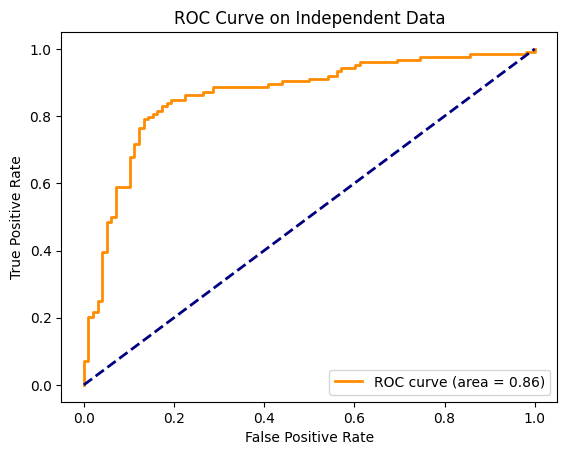

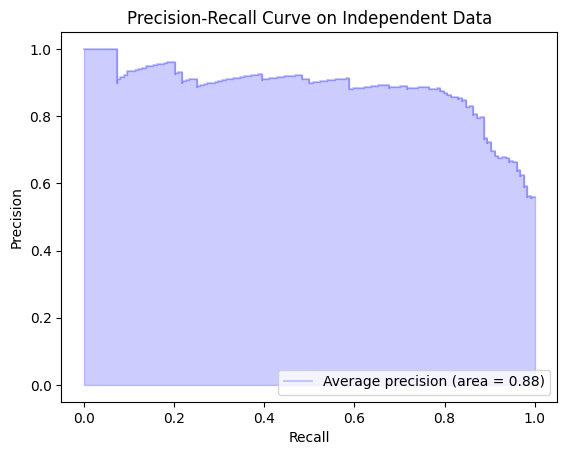

In [7]:
import os
import sys
import math
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import scale
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Input, Dense, Layer, Reshape, Flatten
from tensorflow.keras.layers import multiply, Add, Permute
from tensorflow.keras.layers import Dropout, Lambda, Concatenate, Multiply
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.optimizers import adam_v2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

BiLSTM=pd.read_csv(r'/kaggle/input/qsar-model/all_BiLSTM_train_2D.csv',header=None)

Attention = pd.read_csv(r'/kaggle/input/qsar-model/all_atten_train_2D.csv',header=None)

dataset = np.column_stack((BiLSTM, Attention))

data_train=np.array(dataset)
data_train=data_train[:1106,:]
[m1,n1]=np.shape(data_train)
# label1=np.ones((int(598),1))#Value can be changed
# label2=np.zeros((int(508 ),1))
label1=np.ones((598,1))#Value can be changed
label2=np.zeros((508,1))
label=np.append(label1,label2)
shu=scale(data_train)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(shu, label, test_size=0.2, random_state=42)

X_ind_test = xt
# X_independent = shu.reshape(m1, n1, 1)
# Xt=np.reshape(test_data,(-1,1,n1))
y_ind_test = yt

# Scale the independent data using the same scaling method as the training data
def scale_mean_var(input_arr, axis=0):
    mean_ = np.mean(input_arr, axis=0)
    scale_ = np.std(input_arr, axis=0)
    output_arr = input_arr - mean_
    mean_1 = output_arr.mean(axis=0)
    if not np.allclose(mean_1, 0):
        output_arr -= mean_1
    scale_[scale_ == 0.0] = 1.0
    output_arr /= scale_
    mean_2 = output_arr.mean(axis=0)
    if not np.allclose(mean_2, 0):
        output_arr -= mean_2
    return output_arr

# Scale the independent test data
X_ind_test_scaled = scale_mean_var(X_ind_test)

# Load the pre-trained model
discriminator = load_model('/kaggle/working/models/discriminator_model_fold_2.h5')
generator = load_model('/kaggle/working/models/generator_model_fold_2.h5')

# Build the combined model
z = Input(shape=(X_ind_test_scaled.shape[1],))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# Evaluate the model on the independent test data
y_ind_test_categorical = to_categorical(y_ind_test)
y_score = combined.predict(X_ind_test_scaled)
y_class = np.argmax(y_score, axis=1)

# Calculate metrics
TP, FP, FN, TN = confusion_matrix(y_ind_test, y_class).ravel()
Sn = TP / (TP + FN)
Sp = TN / (TN + FP)
MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
BACC = 0.5 * Sn + 0.5 * Sp

# ROC curve
fpr, tpr, _ = roc_curve(y_ind_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

# PR curve
precision, recall, _ = precision_recall_curve(y_ind_test, y_score[:, 1])
average_precision = average_precision_score(y_ind_test, y_score[:, 1])

# Output results
print(f"BACC: {BACC:.3f}")
print(f"Sn: {Sn:.3f}")
print(f"Sp: {Sp:.3f}")
print(f"MCC: {MCC:.3f}")
print(f"AUC: {roc_auc:.3f}")
print(f"Average Precision: {average_precision:.3f}")

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Independent Data')
plt.legend(loc="lower right")
plt.show()

# Plot PR curve
plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.2, label='Average precision (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Independent Data')
plt.legend(loc="lower right")
plt.show()


Evaluating model 1/9
BACC: 0.799
Sn: 0.765
Sp: 0.833
MCC: 0.600
AUC: 0.856
Average Precision: 0.875


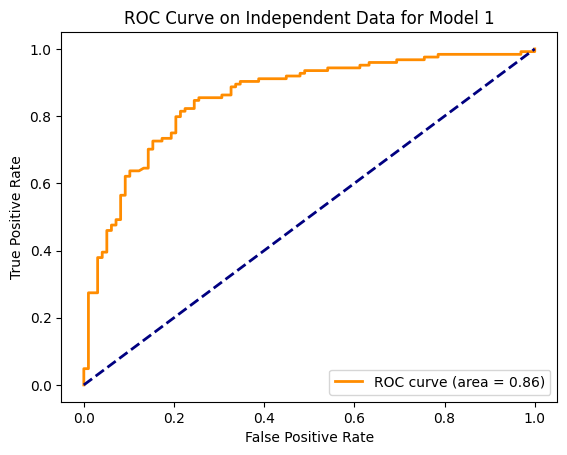

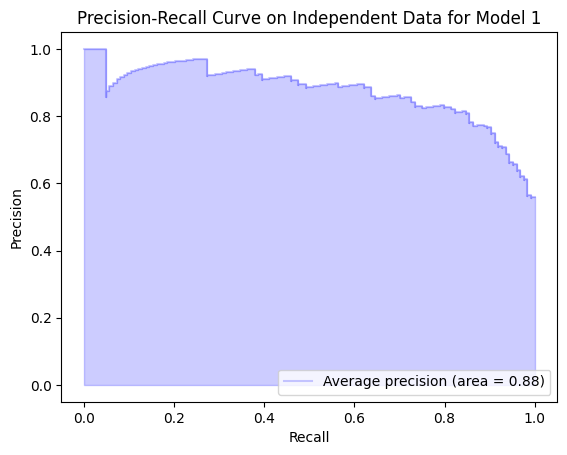

Evaluating model 2/9
BACC: 0.831
Sn: 0.808
Sp: 0.854
MCC: 0.662
AUC: 0.864
Average Precision: 0.881


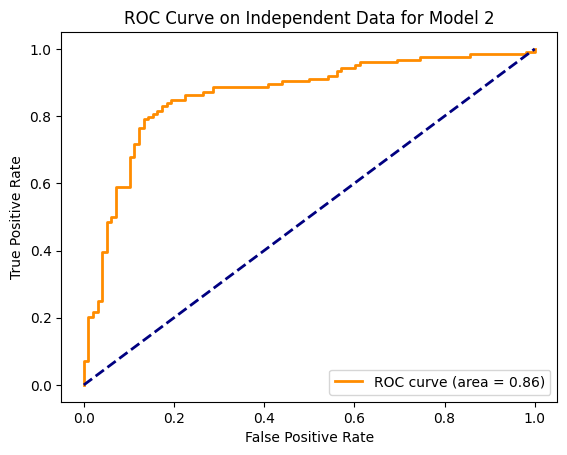

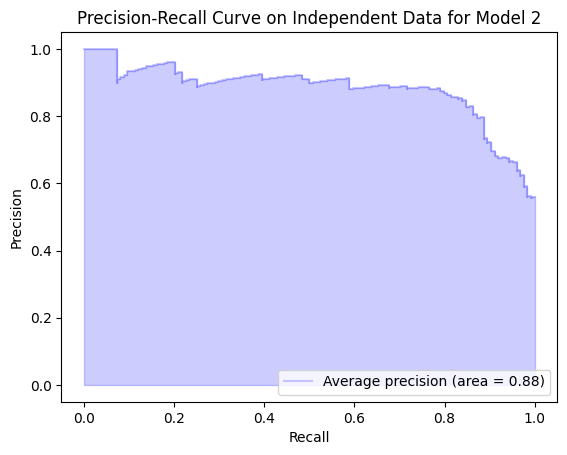

Evaluating model 3/9
BACC: 0.791
Sn: 0.745
Sp: 0.836
MCC: 0.585
AUC: 0.855
Average Precision: 0.864


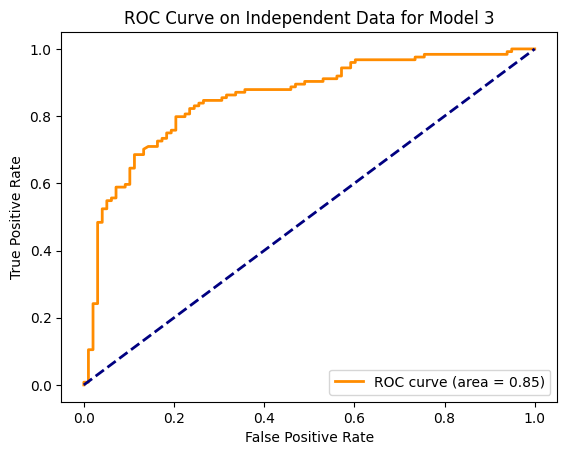

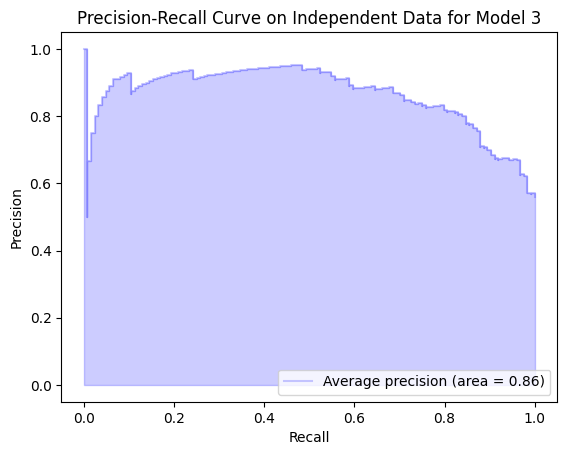

Evaluating model 4/9
BACC: 0.782
Sn: 0.736
Sp: 0.828
MCC: 0.567
AUC: 0.861
Average Precision: 0.884


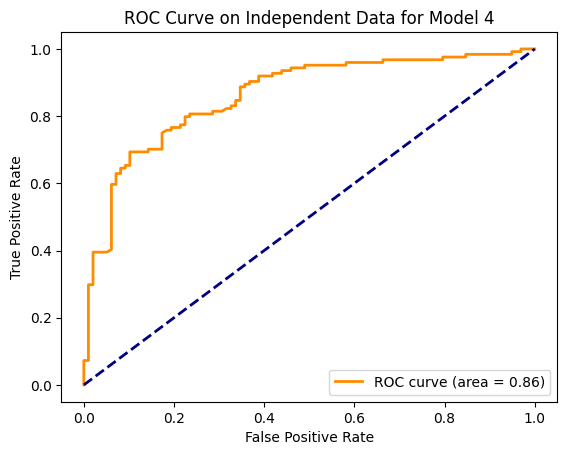

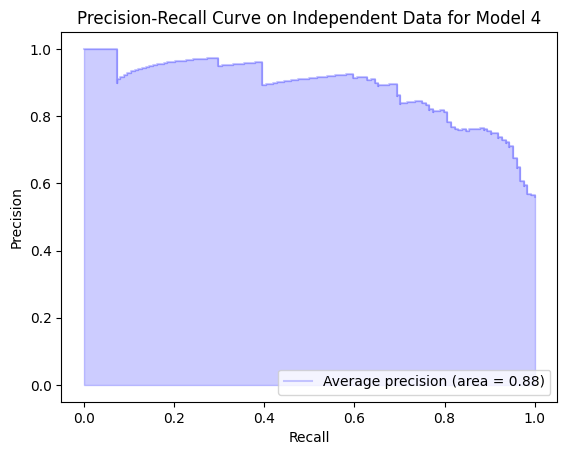

Evaluating model 5/9
BACC: 0.804
Sn: 0.784
Sp: 0.824
MCC: 0.607
AUC: 0.868
Average Precision: 0.875


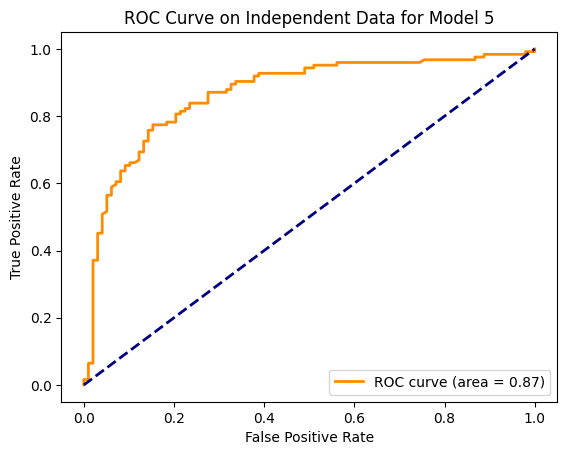

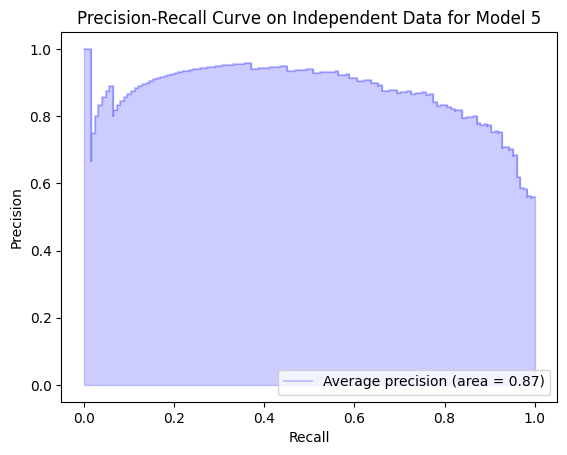

Evaluating model 6/9
BACC: 0.799
Sn: 0.770
Sp: 0.828
MCC: 0.599
AUC: 0.871
Average Precision: 0.889


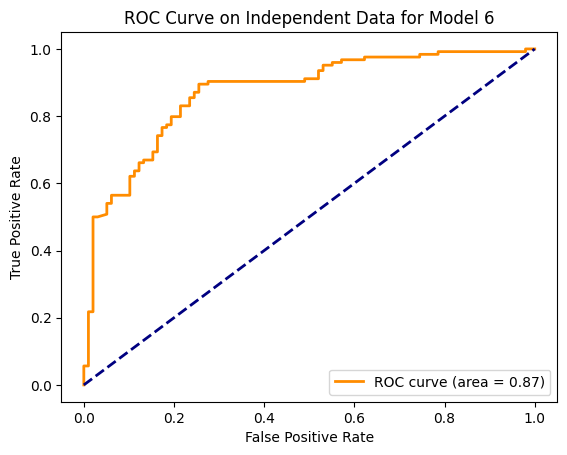

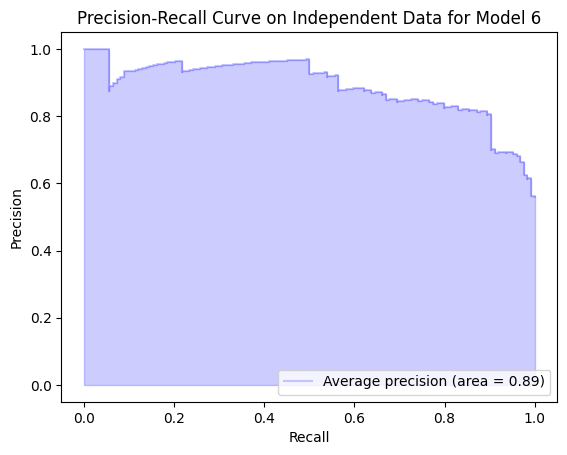

Evaluating model 7/9
BACC: 0.786
Sn: 0.748
Sp: 0.824
MCC: 0.574
AUC: 0.858
Average Precision: 0.893


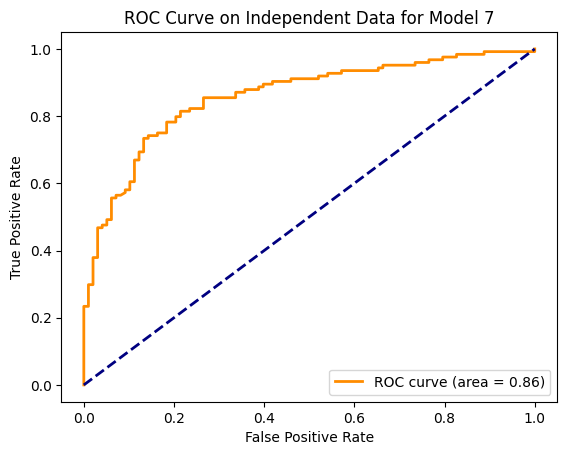

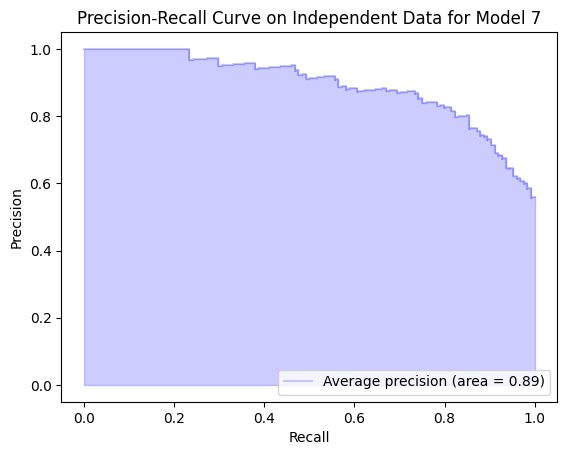

Evaluating model 8/9
BACC: 0.782
Sn: 0.736
Sp: 0.828
MCC: 0.567
AUC: 0.855
Average Precision: 0.861


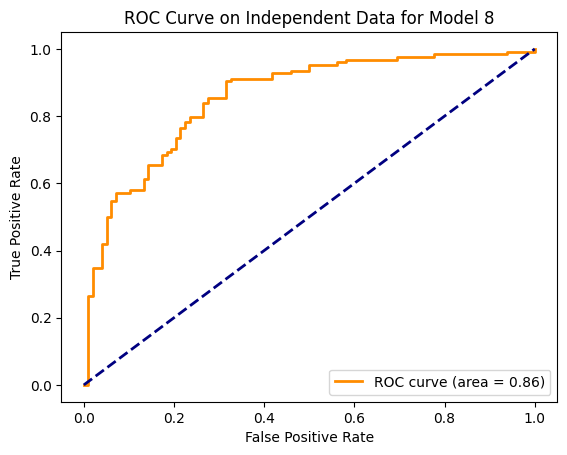

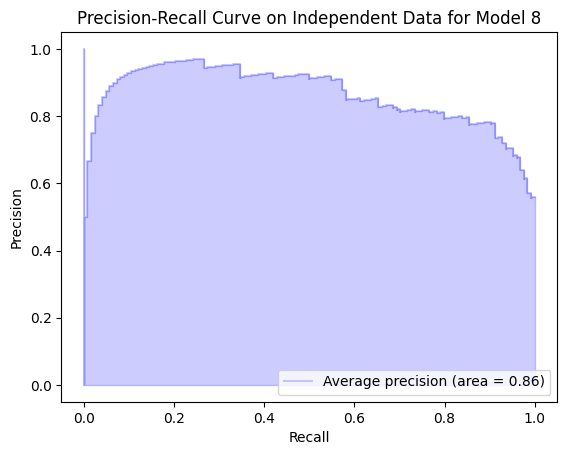

Evaluating model 9/9
BACC: 0.778
Sn: 0.729
Sp: 0.826
MCC: 0.559
AUC: 0.842
Average Precision: 0.854


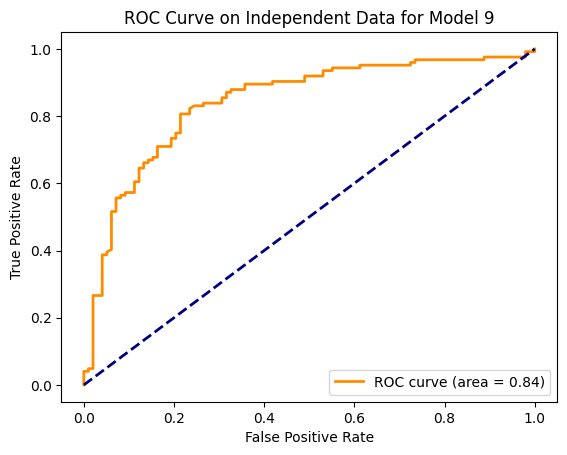

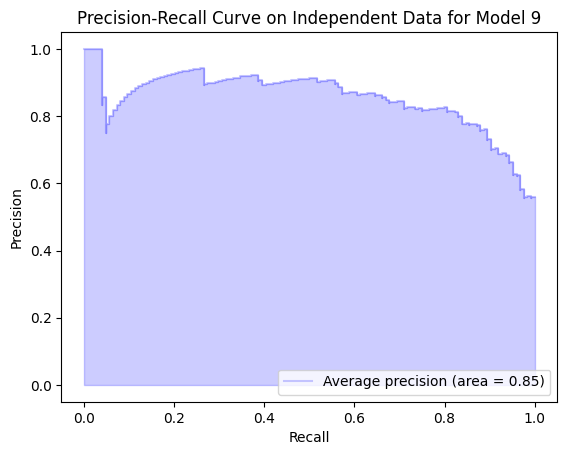

In [6]:
import os
import sys
import math
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import scale
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model

# Load datasets
BiLSTM = pd.read_csv(r'/kaggle/input/qsar-model/all_BiLSTM_train_2D.csv', header=None)
Attention = pd.read_csv(r'/kaggle/input/qsar-model/all_atten_train_2D.csv', header=None)
dataset = np.column_stack((BiLSTM, Attention))

# Prepare training data
data_train = np.array(dataset)[:1106, :]
label1 = np.ones((598, 1))  # Value can be changed
label2 = np.zeros((508, 1))
label = np.append(label1, label2)
shu = scale(data_train)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(shu, label, test_size=0.2, random_state=42)

# Independent test data (Assuming xt and yt are predefined)
X_ind_test = xt
y_ind_test = yt

# Scale the independent data using the same scaling method as the training data
def scale_mean_var(input_arr, axis=0):
    mean_ = np.mean(input_arr, axis=0)
    scale_ = np.std(input_arr, axis=0)
    output_arr = input_arr - mean_
    mean_1 = output_arr.mean(axis=0)
    if not np.allclose(mean_1, 0):
        output_arr -= mean_1
    scale_[scale_ == 0.0] = 1.0
    output_arr /= scale_
    mean_2 = output_arr.mean(axis=0)
    if not np.allclose(mean_2, 0):
        output_arr -= mean_2
    return output_arr

# Scale the independent test data
X_ind_test_scaled = scale_mean_var(X_ind_test)

# List of model filenames
model_files = [f'/kaggle/working/models/discriminator_model_fold_{i}.h5' for i in range(1, 10)]
generator_files = [f'/kaggle/working/models/generator_model_fold_{i}.h5' for i in range(1, 10)]

# Loop through the models and evaluate each
for i, (discriminator_file, generator_file) in enumerate(zip(model_files, generator_files)):
    print(f"Evaluating model {i+1}/{len(model_files)}")

    # Load the pre-trained models
    discriminator = load_model(discriminator_file)
    generator = load_model(generator_file)

    # Build the combined model
    z = Input(shape=(X_ind_test_scaled.shape[1],))
    img = generator(z)
    discriminator.trainable = False
    valid = discriminator(img)
    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

    # Evaluate the model on the independent test data
    y_ind_test_categorical = to_categorical(y_ind_test)
    y_score = combined.predict(X_ind_test_scaled)
    y_class = np.argmax(y_score, axis=1)

    # Calculate metrics
    TP, FP, FN, TN = confusion_matrix(y_ind_test, y_class).ravel()
    Sn = TP / (TP + FN)
    Sp = TN / (TN + FP)
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    BACC = 0.5 * Sn + 0.5 * Sp

    # ROC curve
    fpr, tpr, _ = roc_curve(y_ind_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, _ = precision_recall_curve(y_ind_test, y_score[:, 1])
    average_precision = average_precision_score(y_ind_test, y_score[:, 1])

    # Output results
    print(f"BACC: {BACC:.3f}")
    print(f"Sn: {Sn:.3f}")
    print(f"Sp: {Sp:.3f}")
    print(f"MCC: {MCC:.3f}")
    print(f"AUC: {roc_auc:.3f}")
    print(f"Average Precision: {average_precision:.3f}")

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve on Independent Data for Model {i+1}')
    plt.legend(loc="lower right")
    plt.show()

    # Plot PR curve
    plt.figure()
    plt.step(recall, precision, where='post', color='b', alpha=0.2, label='Average precision (area = %0.2f)' % average_precision)
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on Independent Data for Model {i+1}')
    plt.legend(loc="lower right")
    plt.show()
